# Diamond Price Prediction using Neural Networks

This notebook explores predicting diamond prices using neural networks. We'll analyze a dataset containing various diamond characteristics including carat weight, cut quality, color grade, clarity, and physical measurements to build a model that can accurately predict diamond prices.


## Approach
1. Data preprocessing including:
   - Converting numeric features to float type
   - Encoding categorical variables using Label Encoding
   - Splitting into features (X) and target (y)
2. Model building using neural networks
3. Evaluation of prediction accuracy

## 1. Data Preprocessing


In [1]:
import pandas as pd
import numpy as np

# Load the diamond data file
df = pd.read_csv('diamond-data.txt', sep='\t')

# Drop the first row which contains headers
df = df.iloc[1:]

# Assign column names based on the data
df.columns = ['ID', 'Carat', 'Cut', 'Color', 'Clarity', 'Depth', 'Table', 
             'Price', 'X', 'Y', 'Z', 'Supplier']

# Convert numeric columns to float type
numeric_columns = ['Carat', 'Depth', 'Table', 'Price', 'X', 'Y', 'Z']
df[numeric_columns] = df[numeric_columns].astype(float)

# Convert categorical columns to appropriate types
categorical_columns = ['Cut', 'Color', 'Clarity', 'Supplier']
df[categorical_columns] = df[categorical_columns].astype('category')


In [2]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Handle categorical variables using Label Encoding
label_encoders = {}
for cat_col in categorical_columns:
    label_encoders[cat_col] = LabelEncoder()
    df_processed[cat_col] = label_encoders[cat_col].fit_transform(df_processed[cat_col])

# Split features and target
X = df_processed.drop('Price', axis=1)  # Features
y = df_processed['Price']  # Target variable

print("Data preprocessing completed:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Data preprocessing completed:
Features shape: (53939, 11)
Target shape: (53939,)


## 2. Model Building and Training

The data is split into 20% training and 80% testing. The neural network has 

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import optuna

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# First split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)

# Create custom dataset
class DiamondDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create training dataset and loader
train_dataset = DiamondDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network
class DiamondPriceNet(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(DiamondPriceNet, self).__init__()
        layers = []
        prev_size = input_size
        
        for size in layer_sizes:
            layers.append(nn.Linear(prev_size, size))
            layers.append(nn.ReLU())
            prev_size = size
            
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
        print(f"Input Count: {input_size}")
        
    def forward(self, x):
        return self.network(x)

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    n_layers = trial.suggest_int('n_layers', 1, 4)
    weight_decay = trial.suggest_float('weight_decay', 1e-3, 1e-2, log=True)  # L2 regularization
    
    # Build layer sizes
    layer_sizes = []
    for i in range(n_layers):
        layer_sizes.append(trial.suggest_int(f'n_units_l{i}', 64, 64))
    
    # Initialize model
    model = DiamondPriceNet(input_size=X.shape[1], layer_sizes=layer_sizes).to(device)
    
    # Set optimizer with L2 regularization (weight decay)
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    criterion = nn.MSELoss()
    
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
    
    # Evaluate on test set
    model.eval()
    test_X = torch.FloatTensor(X_test.values).to(device)
    test_y = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)
    
    with torch.no_grad():
        test_predictions = model(test_X)
        test_loss = criterion(test_predictions, test_y)
    
    return test_loss.item()

# Create and run study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train final model with best parameters
best_layer_sizes = []
for i in range(trial.params['n_layers']):
    best_layer_sizes.append(trial.params[f'n_units_l{i}'])

final_model = DiamondPriceNet(input_size=X.shape[1], layer_sizes=best_layer_sizes).to(device)

if trial.params['optimizer'] == 'Adam':
    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=trial.params['lr'])
elif trial.params['optimizer'] == 'RMSprop':
    final_optimizer = torch.optim.RMSprop(final_model.parameters(), lr=trial.params['lr'])
else:
    final_optimizer = torch.optim.SGD(final_model.parameters(), lr=trial.params['lr'])

criterion = nn.MSELoss()

# Final training
num_epochs = 100
for epoch in range(num_epochs):
    final_model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        final_optimizer.zero_grad()
        loss.backward()
        final_optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training completed!")

# Get final predictions
test_X = torch.FloatTensor(X_test.values).to(device)
test_y = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

final_model.eval()
with torch.no_grad():
    test_predictions = final_model(test_X).cpu().numpy()
    
test_y_actual = test_y.cpu().numpy()


[I 2025-05-14 14:31:26,268] A new study created in memory with name: no-name-d9ab8cd6-b5ae-4699-8b06-6547763d7cbc


Using device: cuda
Input Count: 11


[I 2025-05-14 14:32:03,747] Trial 0 finished with value: 1396512.25 and parameters: {'lr': 0.0012098146035394478, 'optimizer': 'RMSprop', 'n_layers': 3, 'weight_decay': 0.0014055744391119876, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:32:40,337] Trial 1 finished with value: 2321076.25 and parameters: {'lr': 0.0015283457808177381, 'optimizer': 'RMSprop', 'n_layers': 3, 'weight_decay': 0.001272196685624166, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:33:17,372] Trial 2 finished with value: 2055042.375 and parameters: {'lr': 0.004829968940642801, 'optimizer': 'RMSprop', 'n_layers': 3, 'weight_decay': 0.004941794924089319, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[W 2025-05-14 14:33:43,702] Trial 3 failed with parameters: {'lr': 0.0010657847165509357, 'optimizer': 'SGD', 'n_layers': 1, 'weight_decay': 0.001185124192244169, 'n_units_l0': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:33:43,702] Trial 3 failed with value nan.


Input Count: 11


[W 2025-05-14 14:34:17,062] Trial 4 failed with parameters: {'lr': 0.0031349968740386367, 'optimizer': 'SGD', 'n_layers': 3, 'weight_decay': 0.0033285604981739673, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:34:17,063] Trial 4 failed with value nan.


Input Count: 11


[W 2025-05-14 14:34:43,056] Trial 5 failed with parameters: {'lr': 0.0030035907094981386, 'optimizer': 'SGD', 'n_layers': 1, 'weight_decay': 0.007363250925434059, 'n_units_l0': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:34:43,056] Trial 5 failed with value nan.


Input Count: 11


[I 2025-05-14 14:35:16,891] Trial 6 finished with value: 1472042.375 and parameters: {'lr': 0.005034116829950751, 'optimizer': 'RMSprop', 'n_layers': 2, 'weight_decay': 0.0014626676959501722, 'n_units_l0': 64, 'n_units_l1': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:35:46,773] Trial 7 finished with value: 1397272.125 and parameters: {'lr': 0.005531394912505108, 'optimizer': 'Adam', 'n_layers': 1, 'weight_decay': 0.008169507300217847, 'n_units_l0': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:36:20,398] Trial 8 finished with value: 2351268.75 and parameters: {'lr': 0.003631627735915887, 'optimizer': 'RMSprop', 'n_layers': 2, 'weight_decay': 0.005114632014870342, 'n_units_l0': 64, 'n_units_l1': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:36:50,007] Trial 9 finished with value: 6295550.0 and parameters: {'lr': 0.0052418169521409545, 'optimizer': 'RMSprop', 'n_layers': 1, 'weight_decay': 0.004895036160639911, 'n_units_l0': 64}. Best is trial 0 with value: 1396512.25.


Input Count: 11


[I 2025-05-14 14:37:26,057] Trial 10 finished with value: 1152163.25 and parameters: {'lr': 0.0017294028808872723, 'optimizer': 'Adam', 'n_layers': 2, 'weight_decay': 0.0010469796177006972, 'n_units_l0': 64, 'n_units_l1': 64}. Best is trial 10 with value: 1152163.25.


Input Count: 11


[I 2025-05-14 14:38:04,155] Trial 11 finished with value: 9055005.0 and parameters: {'lr': 0.007019365946926148, 'optimizer': 'RMSprop', 'n_layers': 3, 'weight_decay': 0.005714869164105411, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64}. Best is trial 10 with value: 1152163.25.


Input Count: 11


[W 2025-05-14 14:38:34,586] Trial 12 failed with parameters: {'lr': 0.0015608572740814057, 'optimizer': 'SGD', 'n_layers': 2, 'weight_decay': 0.0010550704181760669, 'n_units_l0': 64, 'n_units_l1': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:38:34,587] Trial 12 failed with value nan.


Input Count: 11


[W 2025-05-14 14:39:06,003] Trial 13 failed with parameters: {'lr': 0.0014875176738235502, 'optimizer': 'SGD', 'n_layers': 2, 'weight_decay': 0.0024004582891391456, 'n_units_l0': 64, 'n_units_l1': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:39:06,003] Trial 13 failed with value nan.


Input Count: 11


[W 2025-05-14 14:39:41,249] Trial 14 failed with parameters: {'lr': 0.0019471742182521124, 'optimizer': 'SGD', 'n_layers': 3, 'weight_decay': 0.0021171386228254954, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:39:41,249] Trial 14 failed with value nan.


Input Count: 11


[I 2025-05-14 14:40:10,172] Trial 15 finished with value: 1999515.875 and parameters: {'lr': 0.0036047064523858563, 'optimizer': 'Adam', 'n_layers': 1, 'weight_decay': 0.0020492271094832053, 'n_units_l0': 64}. Best is trial 10 with value: 1152163.25.


Input Count: 11


[W 2025-05-14 14:40:49,219] Trial 16 failed with parameters: {'lr': 0.00198426177101811, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.002679284710422827, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:40:49,220] Trial 16 failed with value nan.


Input Count: 11


[W 2025-05-14 14:41:27,306] Trial 17 failed with parameters: {'lr': 0.0018962353993635956, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0025083299262541906, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:41:27,306] Trial 17 failed with value nan.


Input Count: 11


[W 2025-05-14 14:42:05,891] Trial 18 failed with parameters: {'lr': 0.0019731865128692233, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.002656314163392747, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:42:05,891] Trial 18 failed with value nan.


Input Count: 11


[W 2025-05-14 14:42:43,973] Trial 19 failed with parameters: {'lr': 0.0020027668192211874, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0026020950600875105, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:42:43,973] Trial 19 failed with value nan.


Input Count: 11


[W 2025-05-14 14:43:22,150] Trial 20 failed with parameters: {'lr': 0.001978247384227094, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0025873446280980017, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:43:22,154] Trial 20 failed with value nan.


Input Count: 11


[W 2025-05-14 14:43:59,318] Trial 21 failed with parameters: {'lr': 0.0020193648207377348, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.002563172054536575, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:43:59,319] Trial 21 failed with value nan.


Input Count: 11


[W 2025-05-14 14:44:36,951] Trial 22 failed with parameters: {'lr': 0.001901766778591438, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0023253523115247397, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:44:36,951] Trial 22 failed with value nan.


Input Count: 11


[W 2025-05-14 14:45:14,210] Trial 23 failed with parameters: {'lr': 0.0019406775670102116, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0025476511171049097, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:45:14,210] Trial 23 failed with value nan.


Input Count: 11


[W 2025-05-14 14:45:51,599] Trial 24 failed with parameters: {'lr': 0.002033665758188017, 'optimizer': 'SGD', 'n_layers': 4, 'weight_decay': 0.0026263963786855417, 'n_units_l0': 64, 'n_units_l1': 64, 'n_units_l2': 64, 'n_units_l3': 64} because of the following error: The value nan is not acceptable.
[W 2025-05-14 14:45:51,599] Trial 24 failed with value nan.


Best trial:
  Value:  1152163.25
  Params: 
    lr: 0.0017294028808872723
    optimizer: Adam
    n_layers: 2
    weight_decay: 0.0010469796177006972
    n_units_l0: 64
    n_units_l1: 64
Input Count: 11
Epoch [10/100], Loss: 3676633.4028
Epoch [20/100], Loss: 2112750.4810
Epoch [30/100], Loss: 1290021.1078
Epoch [40/100], Loss: 908187.5846
Epoch [50/100], Loss: 713305.4023
Epoch [60/100], Loss: 630273.1929
Epoch [70/100], Loss: 809728.8877
Epoch [80/100], Loss: 612642.5220
Epoch [90/100], Loss: 2757071.8413
Epoch [100/100], Loss: 484426.3095
Training completed!


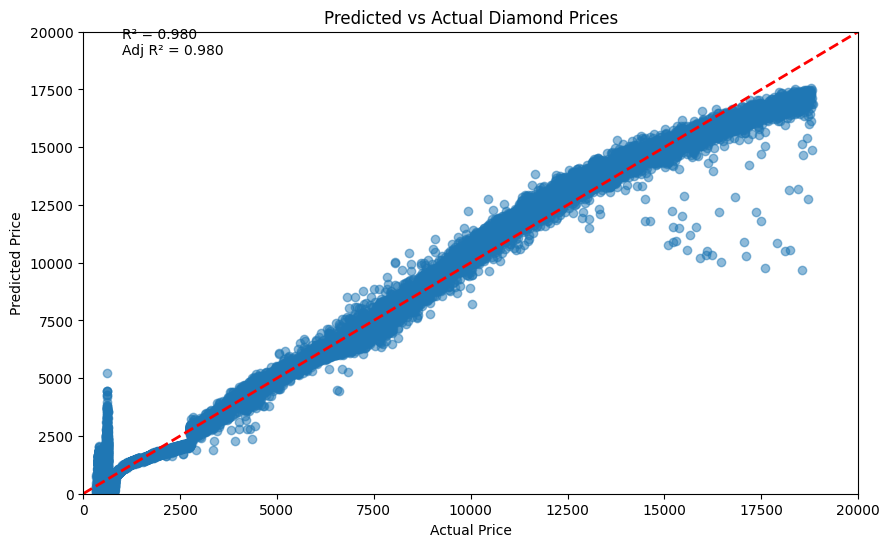

Root Mean Squared Error: $565.33
Mean Absolute Error: $336.57


In [15]:
# Create scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(test_y_actual, test_predictions, alpha=0.5)
plt.plot([0, 20000], [0, 20000], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Diamond Prices')

# Set axis limits
plt.xlim(0, 20000)
plt.ylim(0, 20000)

# Calculate and display R² and adjusted R² scores
from sklearn.metrics import r2_score
r2 = r2_score(test_y_actual, test_predictions)
n = len(test_y_actual)
p = 1  # number of predictors
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nAdj R² = {adj_r2:.3f}', transform=plt.gca().transAxes)

plt.show()

# Print some error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test_y_actual, test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y_actual, test_predictions)

print(f'Root Mean Squared Error: ${rmse:.2f}')
print(f'Mean Absolute Error: ${mae:.2f}')

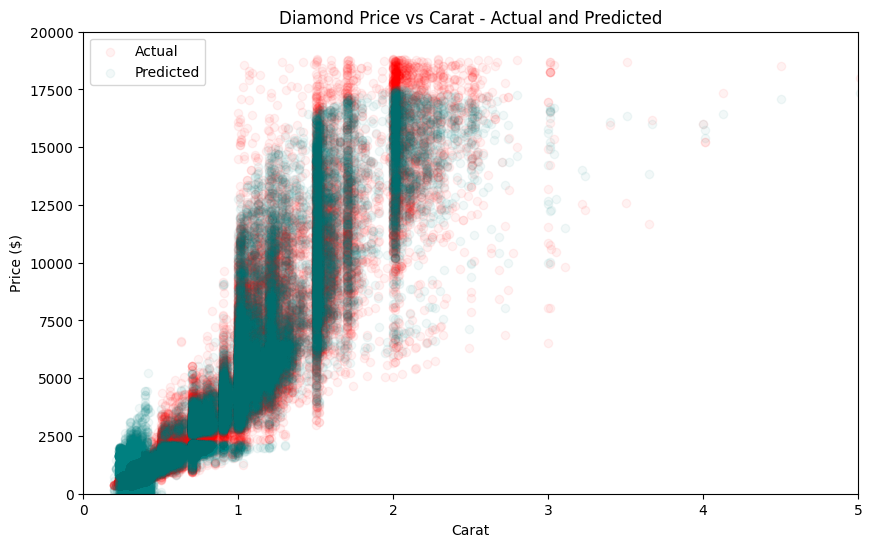

In [16]:
# Create scatter plot of price vs carat
plt.figure(figsize=(10,6))
plt.scatter(df['Carat'], df['Price'], alpha=0.05, label='Actual', color='red')

# Add predicted values from test set
plt.scatter(X_test['Carat'], test_predictions, alpha=0.05, color='teal', label='Predicted')

plt.xlabel('Carat')
plt.ylabel('Price ($)')
plt.title('Diamond Price vs Carat - Actual and Predicted')
plt.legend()

# Set axis limits
plt.xlim(0, 5)
plt.ylim(0, 20000)

plt.show()
